In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import tqdm
import json
import glob
import torch
import warnings
import numpy as np
import torch.nn as nn
from datetime import datetime
import torch.nn.functional as F
import matplotlib.pyplot as plt
from chnet.torchsummary import summary
from toolz.curried import pipe, curry, compose
from torch.utils.data import Dataset, DataLoader

In [3]:
import chnet.utilities as utils
import chnet.cahn_hill as ch
import chnet.ch_tools as tools
from chnet.ch_loader import CahnHillDataset

In [4]:
warnings.filterwarnings('ignore')

## Loss Functions

In [5]:
@curry
def mse_loss(y1, y2, scale=1.):
    """standard MSE definition"""
    return ((y1 - y2) ** 2).sum() / y1.data.nelement() * scale

@curry
def rmse_loss(y1, y2):
    """standard RMSE definition"""
    return ((((y1 - y2) ** 2).sum() / y1.data.nelement()).sqrt()).item()


def mse_loss_npy(y1, y2):
    """standard MSE definition"""
    return np.sum(((y1 - y2) ** 2)) / y1.size

## Data Generators

In [6]:
def prime_magic(n):
    # https://stackoverflow.com/questions/2068372/fastest-way-to-list-all-primes-below-n-in-python/3035188#3035188
    """ Input n>=6, Returns a array of primes, 2 <= p < n """
    sieve = np.ones(n//3 + (n%6==2), dtype=np.bool)
    sieve[0] = False
    for i in range(int(n**0.5)//3+1):
        if sieve[i]:
            k=3*i+1|1
            sieve[      ((k*k)//3)      ::2*k] = False
            sieve[(k*k+4*k-2*k*(i&1))//3::2*k] = False
    return np.r_[2,3,((3*np.nonzero(sieve)[0]+1)|1)]

@curry
def init_norm(nsamples, dim_x, dim_y, seed=354875, m_l=-0.15, m_r=0.15):
    np.random.seed(seed)
    means  = np.random.uniform(m_l, m_r, size=nsamples)
    np.random.seed(seed)
    scales  = np.random.uniform(0.05, 0.3, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.98, 0.98, out=x_data)
    
    return x_data


@curry
def data_generator(nsamples=2, 
                   dim_x=64, 
                   init_steps=1, 
                   delta_sim_steps = 100,
                   dx = 0.25, 
                   dt = 0.01,
                   gamma=1.0, 
                   m_l=-0.15, 
                   m_r=0.15,
                   seed = 354875,
                   device = torch.device("cuda:0")):
    
    init_data = init_norm(nsamples, dim_x, dim_x, seed=seed, m_l=m_l, m_r=m_r)   

    x_data = ch.ch_run_torch(init_data, 
                             dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps, 
                             device=device)    

    y_data = ch.ch_run_torch(x_data, 
                             dt=dt, gamma=gamma, 
                             dx=dx, sim_step=delta_sim_steps, 
                             device=device)    
    return x_data, y_data

# Set Device

In [9]:
device = torch.device('cuda:0')
# device = torch.device('cpu')

In [10]:
from chnet.lstm_unet import Unet_solo

model = Unet_solo(input_nc=1, 
                  output_nc=1, 
                  ngf=32, 
                  k=1, 
                  tanh=True).double().to(device)

In [7]:
primes = prime_magic(1000)

# Analysis of individual model performances

In [74]:
%%time
nsamples=64
dim_x=96
init_steps=1
delta_sim_steps=400
dx = 0.25
dt = 0.01
gamma=1.0


vals_in = data_generator(nsamples=nsamples, 
                          dim_x=dim_x, 
                          init_steps=init_steps, 
                          delta_sim_steps=delta_sim_steps,
                          dx=dx, 
                          dt=dt,
                          gamma=gamma, 
                          seed =174753*primes[0],
                          m_l=-0.15,
                          m_r=0.15,
                          device=device)

vals_le = data_generator(nsamples=nsamples, 
                          dim_x=dim_x, 
                          init_steps=init_steps, 
                          delta_sim_steps=delta_sim_steps,
                          dx=dx, 
                          dt=dt,
                          gamma=gamma, 
                          seed =174753*primes[1],
                          m_l=-0.30,
                          m_r=-0.20,
                          device=device)

vals_rg = data_generator(nsamples=nsamples, 
                          dim_x=dim_x, 
                          init_steps=init_steps, 
                          delta_sim_steps=delta_sim_steps,
                          dx=dx, 
                          dt=dt,
                          gamma=gamma, 
                          seed=174753*primes[2],
                          m_l=0.20,
                          m_r=0.30,
                          device=device)

CPU times: user 367 ms, sys: 90.7 ms, total: 458 ms
Wall time: 464 ms


in_samlple
x1 shape: torch.Size([64, 1, 96, 96])
y1 shape: torch.Size([64, 1, 96, 96])
y2 shape: torch.Size([64, 1, 96, 96])
baseline: 0.0440, predict: 0.0049


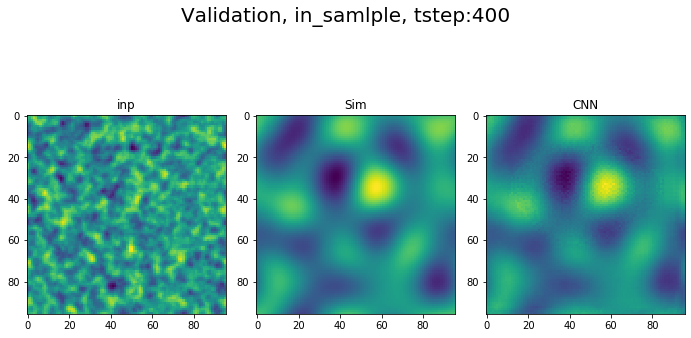

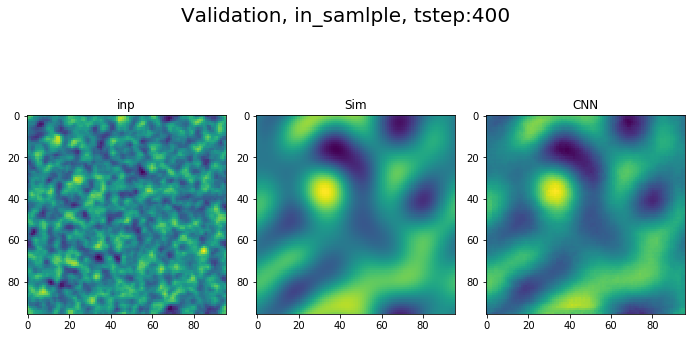

le_sample
x1 shape: torch.Size([64, 1, 96, 96])
y1 shape: torch.Size([64, 1, 96, 96])
y2 shape: torch.Size([64, 1, 96, 96])
baseline: 0.0416, predict: 0.0322


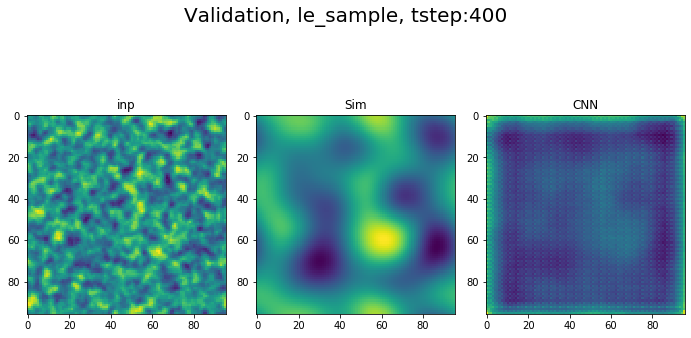

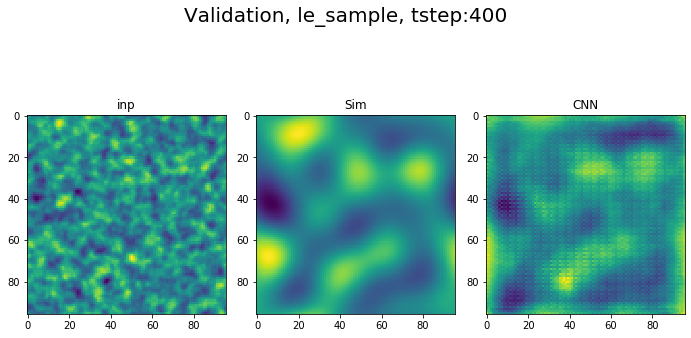

rg_sample
x1 shape: torch.Size([64, 1, 96, 96])
y1 shape: torch.Size([64, 1, 96, 96])
y2 shape: torch.Size([64, 1, 96, 96])
baseline: 0.0398, predict: 0.0286


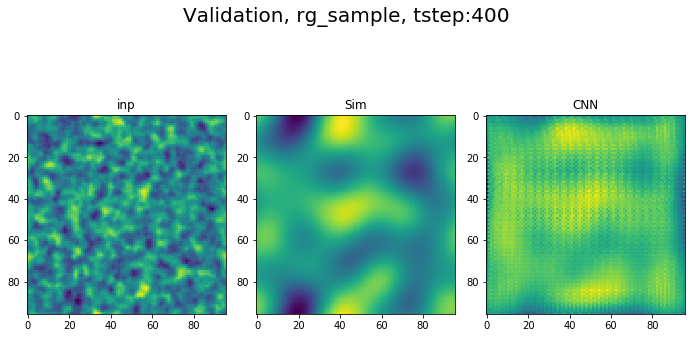

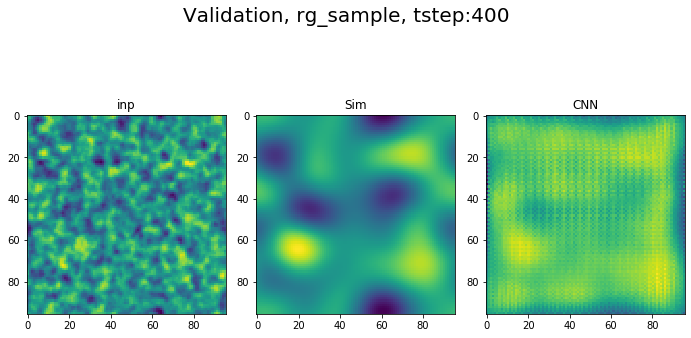

In [79]:
model_name = glob.glob("out/unet_model_ch32_1_{}*".format(delta_sim_steps))[1]
print(model_name)

tags = ["in_samlple", "le_sample", "rg_sample"]

for i0, vals in enumerate([vals_in, vals_le, vals_rg]):
    
    print(tags[i0])
    
    x_val, y_val = vals
    
    val_dataset = CahnHillDataset(x_val, y_val, transform_x= lambda x: x[None], transform_y=lambda x: x[None])
    val_loader = DataLoader(val_dataset, batch_size=nsamples, shuffle=True, num_workers=1)

    item_v = next(iter(val_loader))
    x1 = item_v['x'].to(device)
    y1 = item_v['y'].to(device)

    print("x1 shape: {}".format(x1.shape))
    print("y1 shape: {}".format(y1.shape))

    torch.cuda.empty_cache()
    model.load_state_dict(torch.load(model_name, map_location=device))
    model.eval()

    y2 = model(x1)
    print("y2 shape: {}".format(y2.shape))

    print("baseline: {:1.4f}, predict: {:1.4f}".format(rmse_loss(y1, x1), rmse_loss(y1, y2)))

    for ix in range(2):
        im_x1 = x1[ix][0].detach().cpu().numpy()
        im_y1 = y1[ix][0].detach().cpu().numpy()
        im_y2 = y2[ix][0].detach().cpu().numpy()
        draw_by_side([im_x1, im_y1, im_y2], 
                     title="Validation, {}, tstep:{}".format(tags[i0], delta_sim_steps), 
                     sub_titles=["inp", "Sim", "CNN"])

In [50]:
flist = ['out/unet_model_ch32_1_2000_longrun.pt', 
         'out/unet_model_ch32_2001_2000.pt', 
         'out/unet_model_ch32_4001_2000.pt', 
         'out/unet_model_ch32_6001_2000.pt',]
#          'out/unet_model_ch32_8001_2000.pt']
# flist = ['out/unet_model_ch32_2001_2000.pt', 
#          'out/unet_model_ch32_4001_2000.pt',] 
#          'out/unet_model_ch32_6001_2000.pt',]
#          'out/unet_model_ch32_8001_2000.pt']

In [51]:
len(flist)

4

In [52]:
%%time
nsamples=64
dim_x=96
init_steps=1
delta_sim_steps=2000*len(flist)
dx = 0.25
dt = 0.01
gamma=1.0


vals_in = data_generator(nsamples=nsamples, 
                          dim_x=dim_x, 
                          init_steps=init_steps, 
                          delta_sim_steps=delta_sim_steps,
                          dx=dx, 
                          dt=dt,
                          gamma=gamma, 
                          seed =174753*primes[0],
                          m_l=-0.15,
                          m_r=0.15,
                          device=device)

vals_le = data_generator(nsamples=nsamples, 
                          dim_x=dim_x, 
                          init_steps=init_steps, 
                          delta_sim_steps=delta_sim_steps,
                          dx=dx, 
                          dt=dt,
                          gamma=gamma, 
                          seed =174753*primes[1],
                          m_l=-0.30,
                          m_r=-0.20,
                          device=device)

vals_rg = data_generator(nsamples=nsamples, 
                          dim_x=dim_x, 
                          init_steps=init_steps, 
                          delta_sim_steps=delta_sim_steps,
                          dx=dx, 
                          dt=dt,
                          gamma=gamma, 
                          seed=174753*primes[2],
                          m_l=0.20,
                          m_r=0.30,
                          device=device)

CPU times: user 5.42 s, sys: 1.82 s, total: 7.23 s
Wall time: 7.24 s


in_samlple
x1 shape: torch.Size([64, 1, 96, 96])
y1 shape: torch.Size([64, 1, 96, 96])
y2 shape: torch.Size([64, 1, 96, 96])
baseline: 0.6906, predict: 0.2566


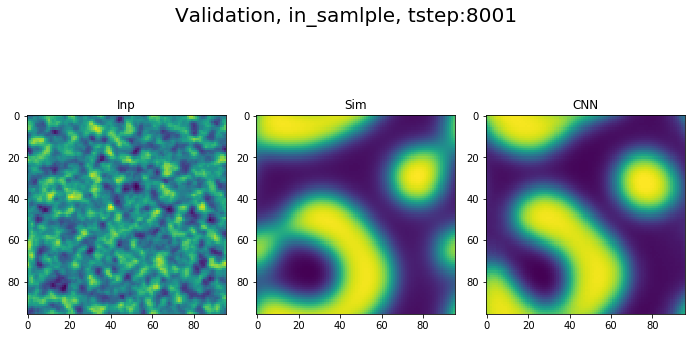

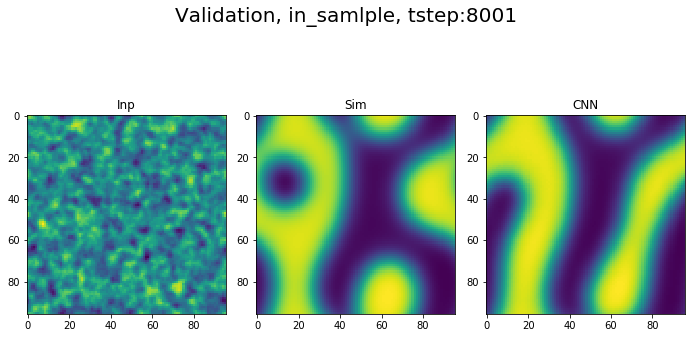

le_sample
x1 shape: torch.Size([64, 1, 96, 96])
y1 shape: torch.Size([64, 1, 96, 96])
y2 shape: torch.Size([64, 1, 96, 96])
baseline: 0.6447, predict: 0.7419


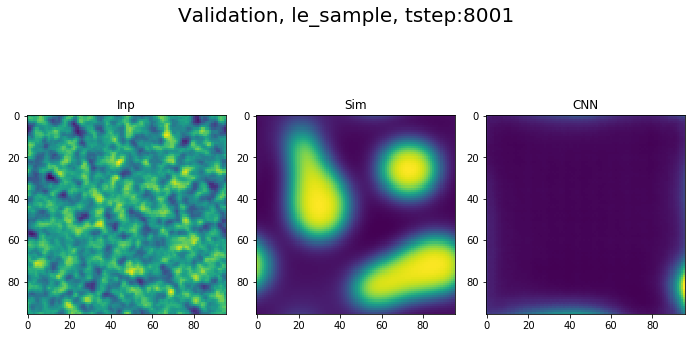

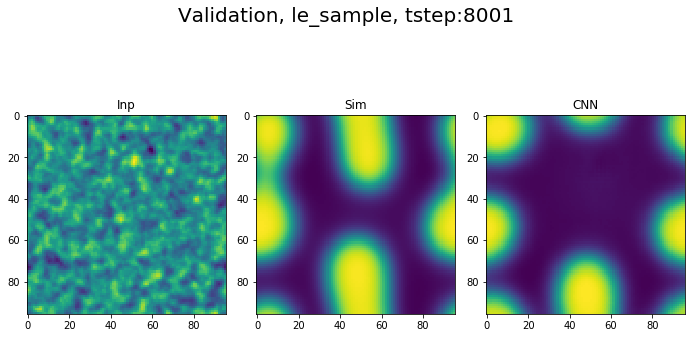

rg_sample
x1 shape: torch.Size([64, 1, 96, 96])
y1 shape: torch.Size([64, 1, 96, 96])
y2 shape: torch.Size([64, 1, 96, 96])
baseline: 0.6463, predict: 0.3598


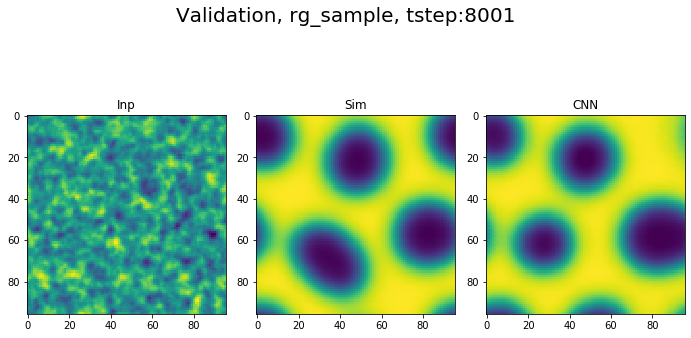

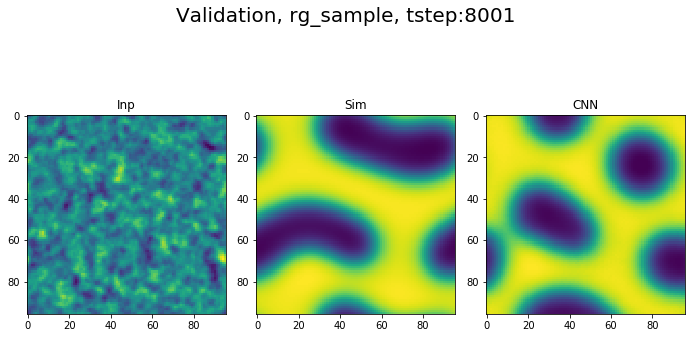

In [53]:
tags = ["in_samlple", "le_sample", "rg_sample"]

for i0, vals in enumerate([vals_in, vals_le, vals_rg]):
    
    print(tags[i0])
    
    x_val, y_val = vals
    
    val_dataset = CahnHillDataset(x_val, y_val, transform_x= lambda x: x[None], transform_y=lambda x: x[None])
    val_loader = DataLoader(val_dataset, batch_size=nsamples, shuffle=True, num_workers=1)

    item_v = next(iter(val_loader))
    x1 = item_v['x'].to(device)
    y1 = item_v['y'].to(device)

    print("x1 shape: {}".format(x1.shape))
    print("y1 shape: {}".format(y1.shape))

    y2 = x1.detach().clone()
    
    for model_name in flist:
        torch.cuda.empty_cache()
        model.load_state_dict(torch.load(model_name, map_location=device))
        model.eval()
        y2 = model(y2)

    print("y2 shape: {}".format(y2.shape))
    print("baseline: {:1.4f}, predict: {:1.4f}".format(rmse_loss(y1, x1), rmse_loss(y1, y2)))

    for ix in range(2):
        im_x1 = x1[ix][0].detach().cpu().numpy()
        im_y1 = y1[ix][0].detach().cpu().numpy()
        im_y2 = y2[ix][0].detach().cpu().numpy()
        utils.draw_by_side([im_x1, im_y1, im_y2], 
                     title="Validation, {}, tstep:{}".format(tags[i0], delta_sim_steps+init_steps), 
                     sub_titles=["Inp", "Sim", "CNN"])

In [ ]:
transformer_x = lambda x: x[None]
transformer_y = lambda x: x[None]


val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
val_loader = DataLoader(val_dataset, batch_size=nsamples, shuffle=True, num_workers=1)

item_v = next(iter(val_loader))
x1 = item_v['x'].to(device)
y1 = item_v['y'].to(device)


# model.load_state_dict(torch.load("out/unet_model_ch32_1_400_longrun.pt", map_location=device))
model.load_state_dict(torch.load("out/unet_model_ch32_1_4000.pt", map_location=device))
model.eval()

y2 = x1.detach().clone()
for _ in range(tsteps):
    y2 = model(y2)


for ix in range(2):
    im_x1 = x1[ix][0].detach().cpu().numpy()
    im_y1 = y1[ix][0].detach().cpu().numpy()
    im_y2 = y2[ix][0].detach().cpu().numpy()

    utils.draw_im(im_x1, "inp")

    utils.draw_by_side(im_y1, im_y2, title_left="Sim", title_right="CNN")

print("baseline: {:1.4f}, predict: {:1.4f}".format(rmse_loss(y1, x1).data, rmse_loss(y1, y2).data))

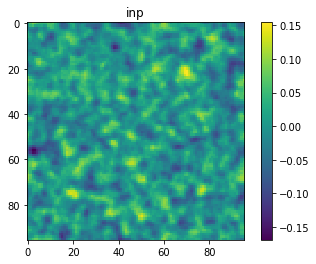

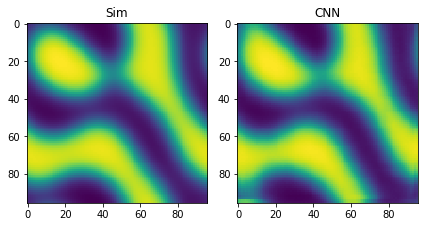

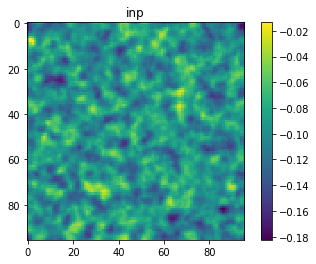

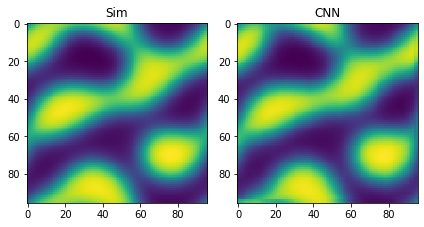

baseline: 0.6278, predict: 0.1099
CPU times: user 1.65 s, sys: 166 ms, total: 1.82 s
Wall time: 2.82 s


In [11]:
%%time
nsamples=32
tsteps=1
step = 4000
x_val, y_val = data_generator(nsamples=nsamples, 
                              dim_x=96, 
                              init_steps=1, 
                              delta_sim_steps=step*tsteps,
                              dx = 0.25, 
                              dt = 0.01,
                              gamma=1.0, 
                              seed =174753,
                              m_l=-0.15,
                              m_r =0.15,
                              device = device)


transformer_x = lambda x: x[None]
transformer_y = lambda x: x[None]


val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
val_loader = DataLoader(val_dataset, batch_size=nsamples, shuffle=True, num_workers=1)

item_v = next(iter(val_loader))
x1 = item_v['x'].to(device)
y1 = item_v['y'].to(device)


# model.load_state_dict(torch.load("out/unet_model_ch32_1_400_longrun.pt", map_location=device))
model.load_state_dict(torch.load("out/unet_model_ch32_1_4000.pt", map_location=device))
model.eval()

y2 = x1.detach().clone()
for _ in range(tsteps):
    y2 = model(y2)


for ix in range(2):
    im_x1 = x1[ix][0].detach().cpu().numpy()
    im_y1 = y1[ix][0].detach().cpu().numpy()
    im_y2 = y2[ix][0].detach().cpu().numpy()

    utils.draw_im(im_x1, "inp")

    utils.draw_by_side(im_y1, im_y2, title_left="Sim", title_right="CNN")

print("baseline: {:1.4f}, predict: {:1.4f}".format(rmse_loss(y1, x1).data, rmse_loss(y1, y2).data))

In [18]:
flist = sorted(glob.glob("out/unet_model_ch32_*_2000.pt"))

flist[0] = "out/unet_model_ch32_1_2000_longrun.pt"

No. of validation steps: 10
out/unet_model_ch32_1_2000_longrun.pt
out/unet_model_ch32_2001_2000.pt
out/unet_model_ch32_4001_2000.pt
out/unet_model_ch32_6001_2000.pt
out/unet_model_ch32_8001_2000.pt


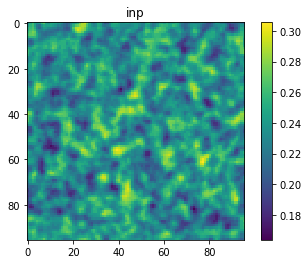

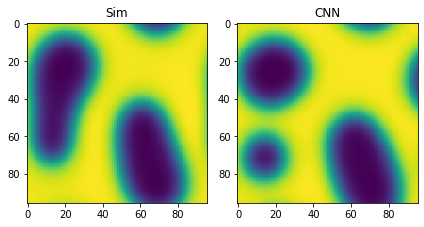

baseline: 0.704, predict: 0.366
out/unet_model_ch32_1_2000_longrun.pt
out/unet_model_ch32_2001_2000.pt
out/unet_model_ch32_4001_2000.pt
out/unet_model_ch32_6001_2000.pt
out/unet_model_ch32_8001_2000.pt


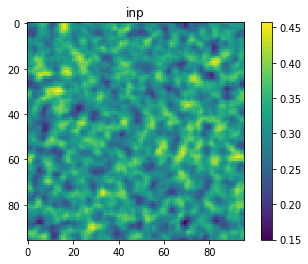

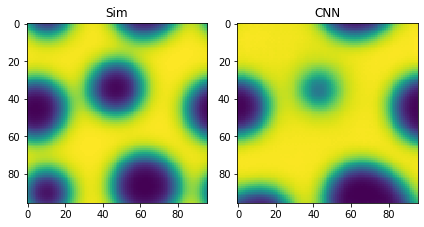

baseline: 0.615, predict: 0.409
out/unet_model_ch32_1_2000_longrun.pt
out/unet_model_ch32_2001_2000.pt
out/unet_model_ch32_4001_2000.pt
out/unet_model_ch32_6001_2000.pt
out/unet_model_ch32_8001_2000.pt


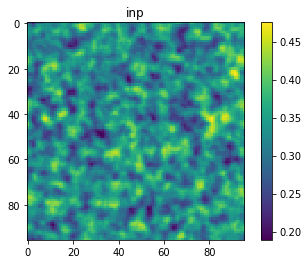

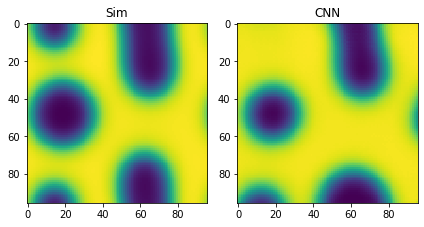

baseline: 0.638, predict: 0.324
out/unet_model_ch32_1_2000_longrun.pt
out/unet_model_ch32_2001_2000.pt
out/unet_model_ch32_4001_2000.pt
out/unet_model_ch32_6001_2000.pt
out/unet_model_ch32_8001_2000.pt


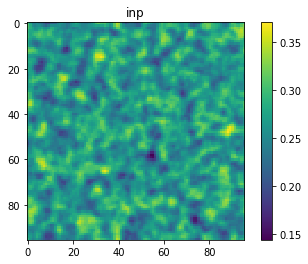

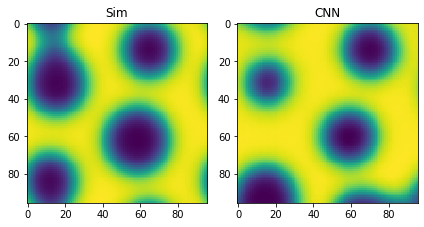

baseline: 0.634, predict: 0.412
out/unet_model_ch32_1_2000_longrun.pt
out/unet_model_ch32_2001_2000.pt
out/unet_model_ch32_4001_2000.pt
out/unet_model_ch32_6001_2000.pt
out/unet_model_ch32_8001_2000.pt


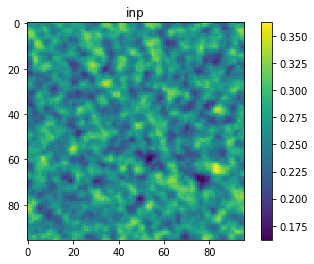

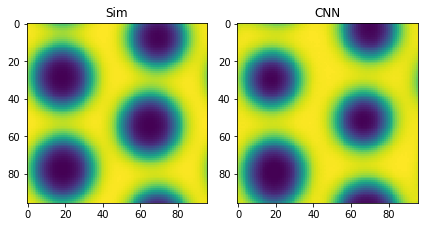

baseline: 0.630, predict: 0.232
out/unet_model_ch32_1_2000_longrun.pt
out/unet_model_ch32_2001_2000.pt
out/unet_model_ch32_4001_2000.pt
out/unet_model_ch32_6001_2000.pt
out/unet_model_ch32_8001_2000.pt


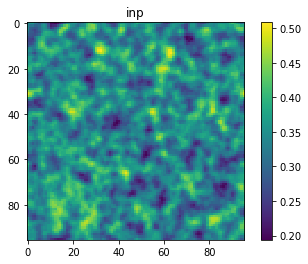

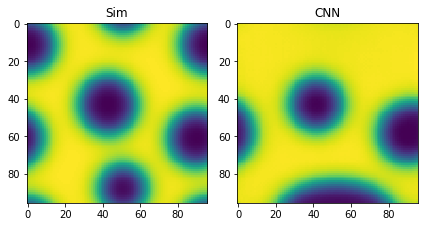

baseline: 0.602, predict: 0.515
out/unet_model_ch32_1_2000_longrun.pt
out/unet_model_ch32_2001_2000.pt
out/unet_model_ch32_4001_2000.pt
out/unet_model_ch32_6001_2000.pt
out/unet_model_ch32_8001_2000.pt


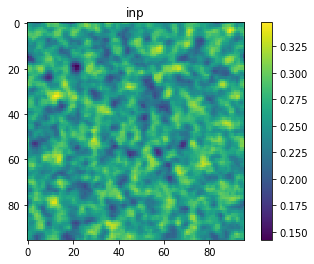

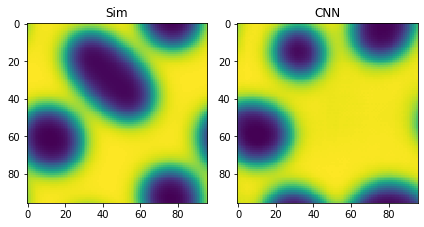

baseline: 0.669, predict: 0.581
out/unet_model_ch32_1_2000_longrun.pt
out/unet_model_ch32_2001_2000.pt
out/unet_model_ch32_4001_2000.pt
out/unet_model_ch32_6001_2000.pt
out/unet_model_ch32_8001_2000.pt


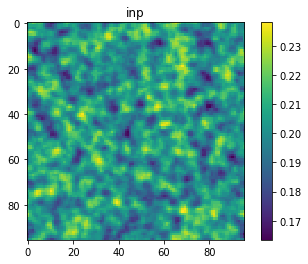

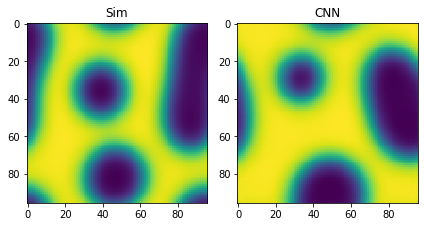

baseline: 0.674, predict: 0.554
out/unet_model_ch32_1_2000_longrun.pt
out/unet_model_ch32_2001_2000.pt
out/unet_model_ch32_4001_2000.pt
out/unet_model_ch32_6001_2000.pt
out/unet_model_ch32_8001_2000.pt


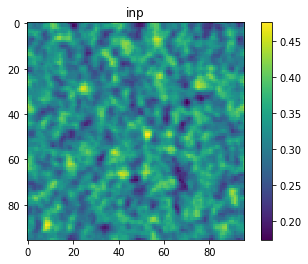

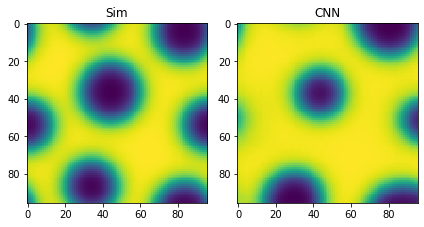

baseline: 0.613, predict: 0.372
out/unet_model_ch32_1_2000_longrun.pt
out/unet_model_ch32_2001_2000.pt
out/unet_model_ch32_4001_2000.pt
out/unet_model_ch32_6001_2000.pt
out/unet_model_ch32_8001_2000.pt


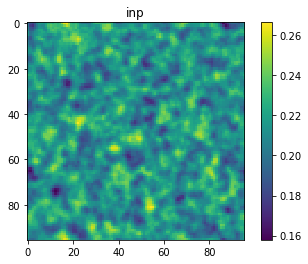

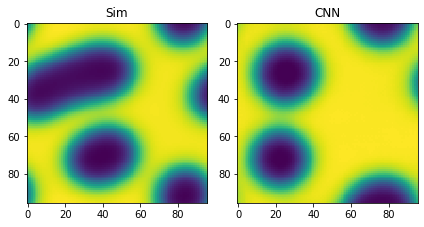

baseline: 0.669, predict: 0.663
CPU times: user 1min 27s, sys: 3.33 s, total: 1min 30s
Wall time: 23 s


In [25]:
%%time
nsamples = 10
x_val, y_val = data_generator(nsamples=nsamples, 
                              dim_x=96, 
                              init_steps=1, 
                              delta_sim_steps=10000,
                              dx = 0.25, 
                              dt = 0.01,
                              gamma=1.0, 
                              seed =174753,
                              m_l=0.2,
                              m_r=0.4,
                              device = device)

transformer_x = lambda x: x[None]
transformer_y = lambda x: x[None]

val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=1)


total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)


for ix in range(nsamples):
    item_v = val_dataset[ix]
    x1 = item_v['x'][None].to(device)
    y1 = item_v['y'][None].to(device)

    y2 = x1.detach().clone()
    for fname in flist:
        print(fname)
        model.load_state_dict(torch.load(fname, map_location=device))
        model.eval()
        y2 = model(y2)

    im_x1 = x1[0].detach().cpu().numpy()
    im_y1 = y1[0].detach().cpu().numpy()
    im_y2 = y2[0].detach().cpu().numpy()

    utils.draw_im(im_x1[0], "inp")
    utils.draw_by_side(im_y1[0], im_y2[0], title_left="Sim", title_right="CNN")

    print("baseline: {:1.3f}, predict: {:1.3f}".format(rmse_loss(y1, x1).data, rmse_loss(y1, y2).data))